# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
!pip install -e .

Obtaining file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


# Question 2 PixelCNNs

Now, we will work with a higher dimensional datasets.
We will start from black-and-white shape dataset and MNIST, in the second part we will extend to modeling colored datasets.

Run the cell below to visualize the two binary datasets.

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
)

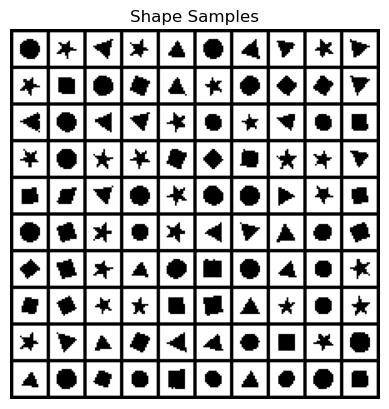

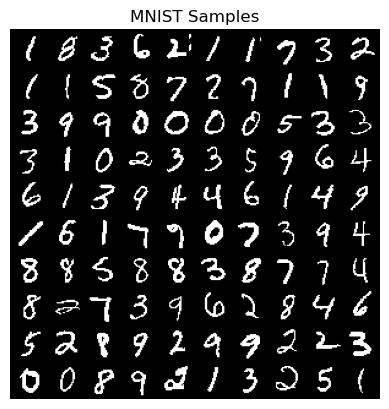

In [4]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images.

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm


class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type='A', **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.ones_like(self.weight))
        self.mask_type = mask_type
        self._make_mask()

    def _make_mask(self):
        k = self.kernel_size[0]
        self.mask[:, :, k//2 + 1:] = 0
        self.mask[:, :, k//2, k//2 + 1:] = 0
        if self.mask_type == 'A':
            self.mask[:, :, k//2, k//2] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [6]:
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64):
        super().__init__()
        
        # Initial masked convolution (type A)
        self.conv_1 = MaskedConv2d(input_channels, hidden_channels, 
                                  kernel_size=7, padding=3, mask_type='A')
        
        # 5 masked convolutions (type B)
        self.conv_layers = nn.ModuleList([
            MaskedConv2d(hidden_channels, hidden_channels, 
                        kernel_size=7, padding=3, mask_type='B')
            for _ in range(5)
        ])
        
        # 2 1x1 convolutions (type B)
        self.conv_1x1_layers = nn.ModuleList([
            MaskedConv2d(hidden_channels, hidden_channels, 
                        kernel_size=1, mask_type='B')
            for _ in range(2)
        ])
        
        # Output layer
        self.output_conv = nn.Conv2d(hidden_channels, 1, kernel_size=1)
        
    def forward(self, x):
        x = F.relu(self.conv_1(x))
        
        for conv in self.conv_layers:
            x = F.relu(conv(x))
            
        for conv in self.conv_1x1_layers:
            x = F.relu(conv(x))
            
        return self.output_conv(x)


In [7]:
from torchsummary import summary
model_summary = PixelCNN()
summary(model_summary, input_size=(1, 20, 20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      MaskedConv2d-1           [-1, 64, 20, 20]           3,200
      MaskedConv2d-2           [-1, 64, 20, 20]         200,768
      MaskedConv2d-3           [-1, 64, 20, 20]         200,768
      MaskedConv2d-4           [-1, 64, 20, 20]         200,768
      MaskedConv2d-5           [-1, 64, 20, 20]         200,768
      MaskedConv2d-6           [-1, 64, 20, 20]         200,768
      MaskedConv2d-7           [-1, 64, 20, 20]           4,160
      MaskedConv2d-8           [-1, 64, 20, 20]           4,160
            Conv2d-9            [-1, 1, 20, 20]              65
Total params: 1,015,425
Trainable params: 1,015,425
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.57
Params size (MB): 3.87
Estimated Total Size (MB): 5.44
---------------------------------------

In [8]:
def binary_cross_entropy_loss(logits, targets):
    """
    Compute binary cross entropy loss properly normalized
    """
    # Convert targets back to [0, 1] range if they're in [-1, 1]
    if targets.min() < 0:
        targets = (targets + 1) / 2.0
    
    # Compute BCE loss
    loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    
    # Average over all dimensions
    return loss.mean()

In [10]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, unit='batch')
    
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()

        logits = model(data)
        loss = binary_cross_entropy_loss(logits, data)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        pbar.set_description(desc=f"batch_loss={loss.item():.4f}")

    return train_losses

In [11]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            logits = model(data)
            loss = binary_cross_entropy_loss(logits, data)
            total_loss += loss.item()

    return total_loss / len(data_loader)


In [12]:
def sample(model, n_samples, image_shape, device):
    model.eval()
    samples = torch.zeros((n_samples, 1, *image_shape), device=device)
    
    with torch.no_grad():
        for i in range(image_shape[0]):
            for j in range(image_shape[1]):
                logits = model(samples)
                probs = torch.sigmoid(logits[:, :, i, j])
                samples[:, :, i, j] = torch.bernoulli(probs)
                
    return samples.cpu().numpy()

In [14]:
def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    torch.manual_seed(1)

    # Set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    else:
        device = torch.device("cpu")
        print("Using CPU")

    # Hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    n_epochs = 5

    if torch.cuda.is_available():
        kwargs = {'num_workers': 4, 'pin_memory': True}
    elif torch.backends.mps.is_available():
        kwargs = {'num_workers': 4}
    else:
        kwargs = {}

    # Prepare data
    train_data = torch.FloatTensor(train_data).permute(0, 3, 1, 2)  # NHWC -> NCHW
    test_data = torch.FloatTensor(test_data).permute(0, 3, 1, 2)

    # Scale to [-1, 1]
    train_data = 2 * train_data - 1
    test_data = 2 * test_data - 1

    # Create dataloaders
    train_dataset = TensorDataset(train_data, torch.zeros(len(train_data)))
    test_dataset = TensorDataset(test_data, torch.zeros(len(test_data)))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, **kwargs)

    # Initialize model
    model = PixelCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    test_losses = [evaluate(model, test_loader, device)]

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(model, train_loader, optimizer, device)
        train_losses.extend(epoch_losses)
        
        test_loss = evaluate(model, test_loader, device)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}/{n_epochs}, Test Loss: {test_loss:.4f}')

    # Generate samples
    samples = sample(model, 100, image_shape, device)
    samples = (samples > 0).astype(np.uint8)  # Convert to binary
    samples = samples.transpose(0, 2, 3, 1)   # NCHW -> NHWC

    return np.array(train_losses), np.array(test_losses), samples


### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Using MPS (Apple Silicon GPU)


  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 1/5, Test Loss: 0.1533


  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 2/5, Test Loss: 0.1455


  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 3/5, Test Loss: 0.1100


  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 4/5, Test Loss: 0.0962


  0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 5/5, Test Loss: 0.0824
Final Test Loss: 0.0824


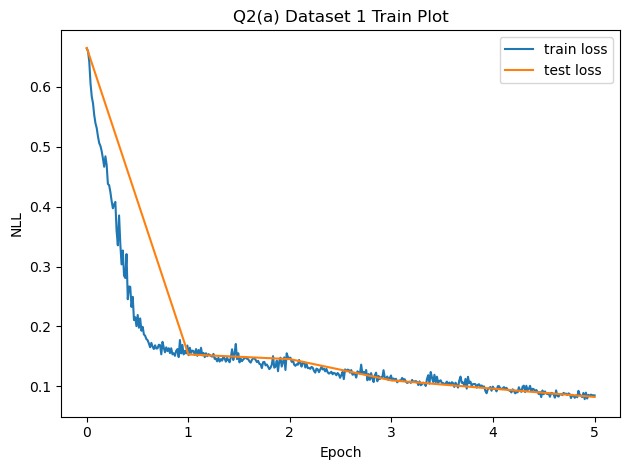

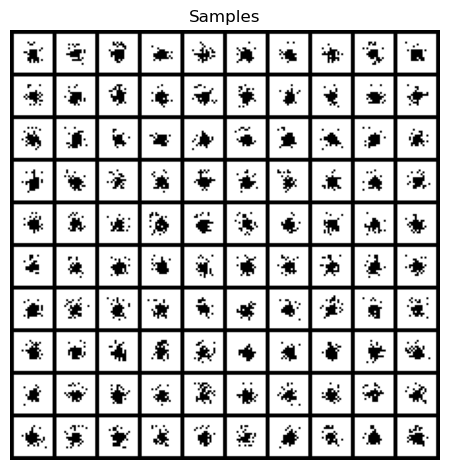

In [15]:
q2a_save_results(1, q2_a)

In [1]:
q2a_save_results(2, q2_a)

NameError: name 'q2a_save_results' is not defined